# 보스턴 주택 가격 데이터 탐색적 분석

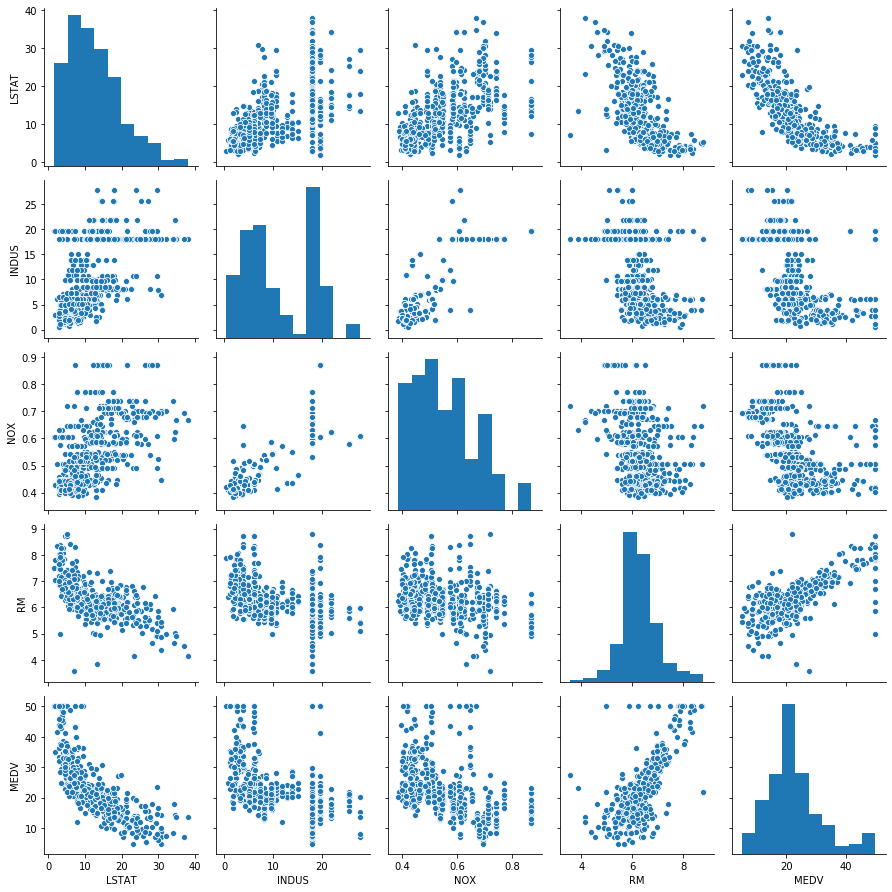

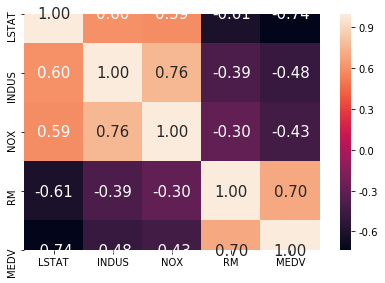

In [77]:
#보스톤 주택 가격 데이터 가져오기
import pandas as pd

df = pd.read_csv('./data/housing_data.txt', sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

%matplotlib inline
#5개 속성의 선형 관계 파악을 위한 데이터 탐색
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()


#5개 속성의 상관계수 확인
import numpy as np
cm = np.corrcoef(df[cols].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

## scipy를 이용한 방개수(RM) 과 주택가격(MEDV)의 단변량 회귀 분석 

기울기: 9.103481556153005
절편: -34.676917909650996
상관계수 0.6953645190298502
불확실성 정도: 3.4536062914897224e-74
방이 4개일 때 주택 가격: 1737.0083149610239 $


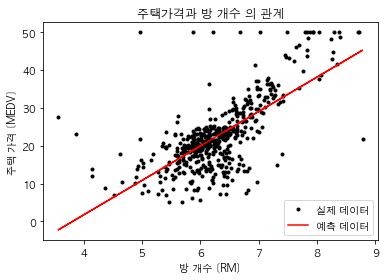

In [96]:
#단변량 회귀 분석
from scipy import stats
slope, intercept, r_value, p_value, stderr = stats.linregress(df['RM'], df['MEDV'])
print("기울기:", slope)
print("절편:", intercept)
print("상관계수", r_value)
print("불확실성 정도:", p_value)
print("방이 4개일 때 주택 가격:", end=' ')
print((4 * slope + intercept) * 1000, '$')
print('=======================================================')

from scipy import polyval
#기존 데이터를 회귀식에 대입해서 list 만들기 
ry = polyval([slope, intercept], df['RM'])

%matplotlib inline
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)



from pylab import plot, title, show, legend
#실제 데이터를 가지고산점도 그리기
plot(df['RM'], df['MEDV'],'k.')

#회귀분석 결과를 가지고 직선 그래프 그리기
plot(df['RM'], ry,'r')


title('주택가격과 방 개수 의 관계')
legend(['실제 데이터', '예측 데이터'])
plt.xlabel('방 개수 [RM]')
plt.ylabel('주택 가격 [MEDV]')
show()

## sklearn - LinearReagression 을 이용한 회귀분석 

기울기: 9.103
절편: -34.677


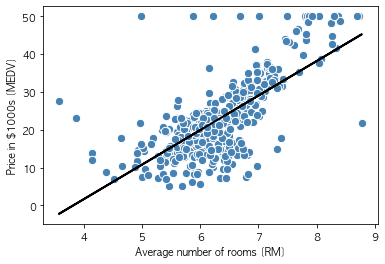

In [97]:
#단병량 회귀 분석 수행
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
X = df[['RM']].values
y = df['MEDV'].values
slr.fit(X, y)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

#실제 데이터와 예측 데이터의 그래프 그리기
import matplotlib.pyplot as plt
plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
plt.plot(X, slr.predict(X), color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

# sklearn - RANSAC 알고리즘 을 이용한 회귀분석 

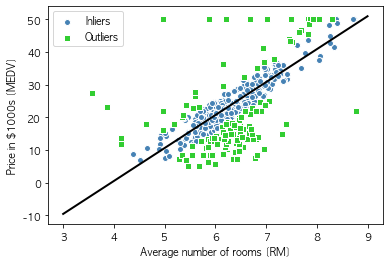

기울기: 10.099
절편: -39.915


In [98]:
from sklearn.linear_model import RANSACRegressor

#RANSAC 알고리즘 수행을 위한 객체 생성
#max_trials는 최대 수행 횟수
#min_samples는 최소 샘플 데이터 개수
#loss는 오차측정 함수를 지정하는 것으로 알고리즘이 학습한 직선과 실제 데이터와의 직선 거리로 설정
#residual_threshold는 잔차의 최대 거리

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)

#선형 회귀분석 수행
ransac.fit(X, y)

#데이터들이 오차 범위 내에 있는지 여부를 저장한 배열을 가져와서 저장
inlier_mask = ransac.inlier_mask_

#배열의 값을 반대로 만들어서 저장
outlier_mask = np.logical_not(inlier_mask)


#그래프를 그릴 범위 설정
line_X = np.arange(3, 10, 1)

#그릴 범위에 해당하는 데이터의 예측값 가져오기
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

#실제 데이터를 산점도로 표현
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
#예측 모델을 선 그래프로 표현
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

## 훈련 데이터를 이용한  회귀분석

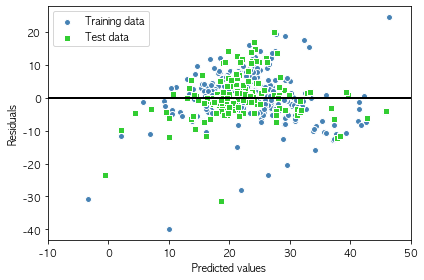

훈련 MSE: 43.402, 테스트 MSE: 44.680
훈련 R^2: 0.499, 테스트 R^2: 0.432


In [99]:
from sklearn.model_selection import train_test_split

#회귀분석 수행
X = df[['RM']].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)

#분석의 결과로나온 모델을 가지고 훈련 데이터와 검증 데이터의 결과를 생성
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

#음수 출력을 위한 설정 - 하지 않으면 음수가 네모로 보임
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

#모델에 의해 나온 데이터와 실제 데이터를 산포도로 출력
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

## 다변량 선형 회귀 

In [100]:
import pandas as pd
#보스톤 주택 가격 데이터 가져오기
df = pd.read_csv('./data/housing_data.txt',
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

# 속성(변수) 선택
X=df.iloc[:, :-1].values  #독립 변수 X1, X2, X3
y=df['MEDV'].values     #종속 변수 Y

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

# sklearn 라이브러리에서 선형회귀분석 모듈 가져오기
from sklearn.linear_model import LinearRegression

# 단순회귀분석 모형 객체 생성
lr = LinearRegression()   

# train data를 가지고 모형 학습
lr.fit(X_train, y_train)

# 학습을 마친 모형에 test data를 적용하여 결정계수(R-제곱) 계산
r_square = lr.score(X_test, y_test)
print(r_square)
print('\n')

# 회귀식의 기울기
print('X 변수의 기울기 a: ', lr.coef_)
print('\n')

# 회귀식의 y절편
print('절편', lr.intercept_)
print('\n')

0.7464118049312574


X 변수의 기울기 a:  [-9.86857935e-02  5.10508891e-02 -1.03431329e-02  2.82079988e+00
 -1.68487976e+01  3.61984237e+00 -6.52912844e-03 -1.58231648e+00
  2.52149467e-01 -1.16715580e-02 -9.03003609e-01  6.53431831e-03
 -5.15578561e-01]


절편 38.50384981552739




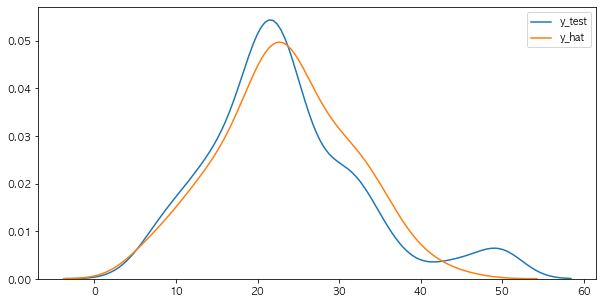

In [101]:
# train data의 산점도와 test data로 예측한 회귀선을 그래프로 출력 
y_hat = lr.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10, 5))
ax1 = sns.distplot(y_test, hist=False, label="y_test")
ax2 = sns.distplot(y_hat, hist=False, label="y_hat", ax=ax1)
plt.show()
plt.close()

# statsmodels 패키지를 이용한 다변량 회귀 분석 

In [102]:
import pandas as pd
import statsmodels.formula.api as sm
df = pd.read_csv("./data/score.csv", encoding="ms949")

result = sm.ols(formula = 'score ~ iq + academy + game + tv', data = df).fit()

print('절편과 기울기')
print(result.params)
print()
print('유의확률:' , result.pvalues)
print()

print('결정계수:' , result.rsquared)

print('각 학생의 예측 점수:', result.predict())

#IQ가 130이고 학원을 3개 다니고 게임을 2시간하고 TV를 1시간 보는 학생의 예측 점수는?
y = result.params.Intercept + 130*result.params.iq + 3*result.params.academy + 2*result.params.game+1*result.params.tv
print("예측점수:" , y)

절편과 기울기
Intercept    23.299232
iq            0.468422
academy       0.717901
game         -0.838955
tv           -1.385408
dtype: float64

유의확률: Intercept    0.117508
iq           0.003376
academy      0.534402
game         0.131001
tv           0.184269
dtype: float64

결정계수: 0.9608351062148871
각 학생의 예측 점수: [89.47516936 75.89680196 74.68614801 82.68433242 63.58609587 80.84448722
 82.54342107 72.89049111 86.12886227 80.2641907 ]
예측점수: 83.28448678034155


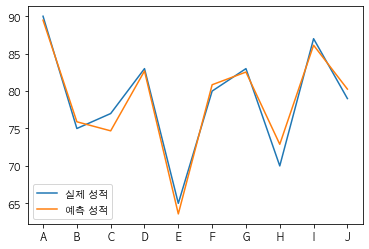

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(df['score'], label='실제 성적')
plt.plot(result.predict(), label='예측 성적')
plt.xticks(range(0,10,1),df['name'])
plt.legend();
plt.show()

## 회귀에 규제 적용

In [105]:
import pandas as pd
#보스톤 주택 가격 데이터 가져오기
df = pd.read_csv('./data/housing_data.txt',
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

# 속성(변수) 선택
X=df.iloc[:, :-1].values  #독립 변수 X1, X2, X3
y=df['MEDV'].values     #종속 변수 Y

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

# sklearn 라이브러리에서 선형회귀분석 모듈 가져오기
from sklearn.linear_model import LinearRegression

# 단순회귀분석 모형 객체 생성
lr = LinearRegression()   

# train data를 가지고 모형 학습
lr.fit(X_train, y_train)

print('일반 다변량 분석 결과')
print("훈련 세트 결정계수: {:.2f}".format(lr.score(X_train, y_train)))
print("테스트 세트 결정계수: {:.2f}".format(lr.score(X_test, y_test)))
# 회귀식의 기울기
print('X 변수의 기울기 a: ', lr.coef_)
# 회귀식의 y절편
print('절편', lr.intercept_)

print("==========================")
#릿지 회귀
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0).fit(X_train, y_train)
print('릿지 회귀 다변량 분석 결과')
print("훈련 세트 결정계수: {:.2f}".format(ridge.score(X_train, y_train)))
print("테스트 세트 결정계수: {:.2f}".format(ridge.score(X_test, y_test)))
print('X 변수의 기울기 a: ', ridge.coef_)
# 회귀식의 y절편
print('절편', ridge.intercept_)
print("==========================")
#라쏘 회귀
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0).fit(X_train, y_train)
print('라쏘 회귀 다변량 분석 결과')
print("훈련 세트 결정계수: {:.2f}".format(lasso.score(X_train, y_train)))
print("테스트 세트 결정계수: {:.2f}".format(lasso.score(X_test, y_test)))
print('X 변수의 기울기 a: ', lasso.coef_)
# 회귀식의 y절편
print('절편', lasso.intercept_)

일반 다변량 분석 결과
훈련 세트 결정계수: 0.74
테스트 세트 결정계수: 0.75
X 변수의 기울기 a:  [-9.86857935e-02  5.10508891e-02 -1.03431329e-02  2.82079988e+00
 -1.68487976e+01  3.61984237e+00 -6.52912844e-03 -1.58231648e+00
  2.52149467e-01 -1.16715580e-02 -9.03003609e-01  6.53431831e-03
 -5.15578561e-01]
절편 38.50384981552739
릿지 회귀 다변량 분석 결과
훈련 세트 결정계수: 0.73
테스트 세트 결정계수: 0.74
X 변수의 기울기 a:  [-9.44429494e-02  5.20765307e-02 -4.35636292e-02  2.68045113e+00
 -8.77726410e+00  3.66584906e+00 -1.40606312e-02 -1.46592426e+00
  2.34601620e-01 -1.23672344e-02 -8.11961287e-01  6.81930515e-03
 -5.26738208e-01]
절편 32.98305013334272
라쏘 회귀 다변량 분석 결과
훈련 세트 결정계수: 0.68
테스트 세트 결정계수: 0.68
X 변수의 기울기 a:  [-0.04511802  0.0524456  -0.          0.         -0.          0.85592791
  0.01624632 -0.74222814  0.20995366 -0.01426041 -0.68854527  0.00625912
 -0.75933252]
절편 42.39229513430264


## 단항식과 다항식 비교

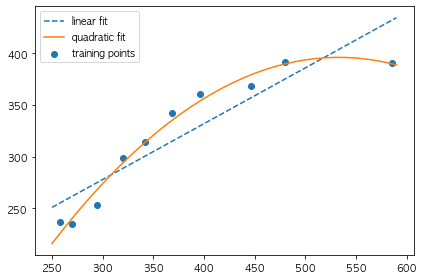

In [106]:
import numpy as np
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# 선형 특성 학습
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 이차항 특성 학습
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

import matplotlib.pyplot as plt
%matplotlib inline
# 결과 그래프
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 다항식을 적용한 단변량 회귀 분석 

In [107]:
import pandas as pd

#데이터 읽어오기
df = pd.read_csv('./data/housing_data.txt', sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()


#회귀분석을 수행할 데이터 추출
X = df[['LSTAT']].values
y = df['MEDV'].values

#훈련 데이터와 테스트 데이터를 7:3으로 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


from sklearn.preprocessing import PolynomialFeatures   #다항식 변환
# 다항식 변환 
poly = PolynomialFeatures(degree=2, include_bias=False)               

#데이터 변환
X_train_poly=poly.fit_transform(X_train)
X_test_poly=poly.fit_transform(X_test)

print('원래 데이터: ', X_train.shape)
print(X_train[0:5])
print('2차항 변환 데이터: ', X_train_poly.shape)  
print(X_train_poly[0:5])

print('원래 데이터: ', X_test.shape)
print('2차항 변환 데이터: ', X_test_poly.shape)  

원래 데이터:  (353, 1)
[[16.9 ]
 [ 8.61]
 [25.41]
 [19.88]
 [ 8.79]]
2차항 변환 데이터:  (353, 2)
[[ 16.9    285.61  ]
 [  8.61    74.1321]
 [ 25.41   645.6681]
 [ 19.88   395.2144]
 [  8.79    77.2641]]
원래 데이터:  (152, 1)
2차항 변환 데이터:  (152, 2)


In [108]:
# sklearn 라이브러리에서 필요한 모듈 가져오기 
from sklearn.linear_model import LinearRegression      
#선형회귀분석 수행
slr = LinearRegression()

#회귀분석
slr.fit(X_train_poly, y_train)

print("기울기:", slr.coef_)
print("절편:", slr.intercept_)

기울기: [-2.38456737  0.04428433]
절편: 43.28054255775667


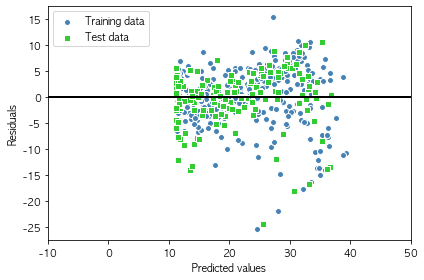

In [110]:
#분석의 결과로나온 모델을 가지고 훈련 데이터와 검증 데이터의 결과를 생성
y_train_pred = slr.predict(X_train_poly)
y_test_pred = slr.predict(X_test_poly)

import matplotlib.pyplot as plt
%matplotlib inline

#음수 출력을 위한 설정 - 하지 않으면 음수가 네모로 보임
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

#모델에 의해 나온 데이터와 실제 데이터를 산포도로 출력
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

In [111]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 30.489, 테스트 MSE: 29.851
훈련 R^2: 0.648, 테스트 R^2: 0.621


# 의사결정나무

In [112]:
import numpy as np
import pandas as pd

#데이터 읽어오기
df = pd.read_csv('./data/housing_data.txt', sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()
X = df[['LSTAT']].values
y = df['MEDV'].values

from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred = tree.predict(X)

print('mse:',mean_squared_error(y, y_pred))
print('결정계수:',r2_score(y, y_pred))

mse: 25.342180043347035
결정계수: 0.7003848989398793


# 랜덤 포리스트 회귀

In [113]:
import pandas as pd

#데이터 읽어오기
df = pd.read_csv('./data/housing_data.txt', sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()
X = df[['LSTAT']].values
y = df['MEDV'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

In [114]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()

slr.fit(X_train, y_train)
#분석의 결과로나온 모델을 가지고 훈련 데이터와 검증 데이터의 결과를 생성
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 36.755, 테스트 MSE: 42.644
훈련 R^2: 0.553, 테스트 R^2: 0.525


In [115]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 6.831, 테스트 MSE: 38.290
훈련 R^2: 0.917, 테스트 R^2: 0.574
